In [1]:
%matplotlib inline

In [2]:
import pandas as pd
pd.set_option("display.width", 100)
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm

In [3]:
experiments = pd.read_csv('../evaluation/resources/2020/all_experiments.csv')  
experiments = experiments.fillna('-')


/home/pilmus/thesis/venv37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (13,14,15,16,17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
experiments.head()

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,util,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor
0,0.093994,1.764305,1.391840,0.505467,0.187961,0.061738,0.128527,3462,ac,lambdamart_err_mpt_10_0.1,auth,ind,99.0,linear,-,-,-,-,-
1,0.458239,1.349019,0.890975,0.861252,0.504215,0.212971,0.214348,8940,ac,lambdamart_err_mpt_10_0.1,auth,ind,99.0,linear,-,-,-,-,-
2,0.211752,2.205880,1.601764,0.376448,0.200894,0.089654,0.230992,10795,ac,lambdamart_err_mpt_10_0.1,auth,ind,99.0,linear,-,-,-,-,-
3,0.203045,1.059265,0.758689,0.269296,0.187771,0.040046,0.225679,12073,ac,lambdamart_err_mpt_10_0.1,auth,ind,99.0,linear,-,-,-,-,-
4,0.119569,1.875785,1.744386,0.803781,0.281360,0.129826,0.132375,12096,ac,lambdamart_err_mpt_10_0.1,auth,ind,99.0,linear,-,-,-,-,-


## Is the LM baseline improved by accuracy-oriented changes?

### Select LambdaMart data

In [5]:
lambdata = experiments[experiments.ranker == 'lambdamart']
lambdata = lambdata.reset_index(drop=True)
lambdata.head()

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,util,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor
0,0.211684,1.964629,1.433157,1.686451,1.329427,0.041978,0.087503,3462,lambdamart,-,-,-,-,-,aug0.5,err,mpt,10,0.1
1,1.071827,2.173456,0.996399,1.904734,1.329427,0.103836,0.087910,8940,lambdamart,-,-,-,-,-,aug0.5,err,mpt,10,0.1
2,0.698335,3.454949,1.983007,1.538637,1.317708,0.066966,0.175418,10795,lambdamart,-,-,-,-,-,aug0.5,err,mpt,10,0.1
3,0.809104,1.659759,0.755906,1.460666,1.329427,0.015189,0.087618,12073,lambdamart,-,-,-,-,-,aug0.5,err,mpt,10,0.1
4,0.246748,2.390579,1.938194,2.079445,1.333318,0.017973,0.005475,12096,lambdamart,-,-,-,-,-,aug0.5,err,mpt,10,0.1


### Visualize relations

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", color_codes=True)

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm



#### eel_diff

<AxesSubplot:xlabel='feature_method', ylabel='difference_ind'>

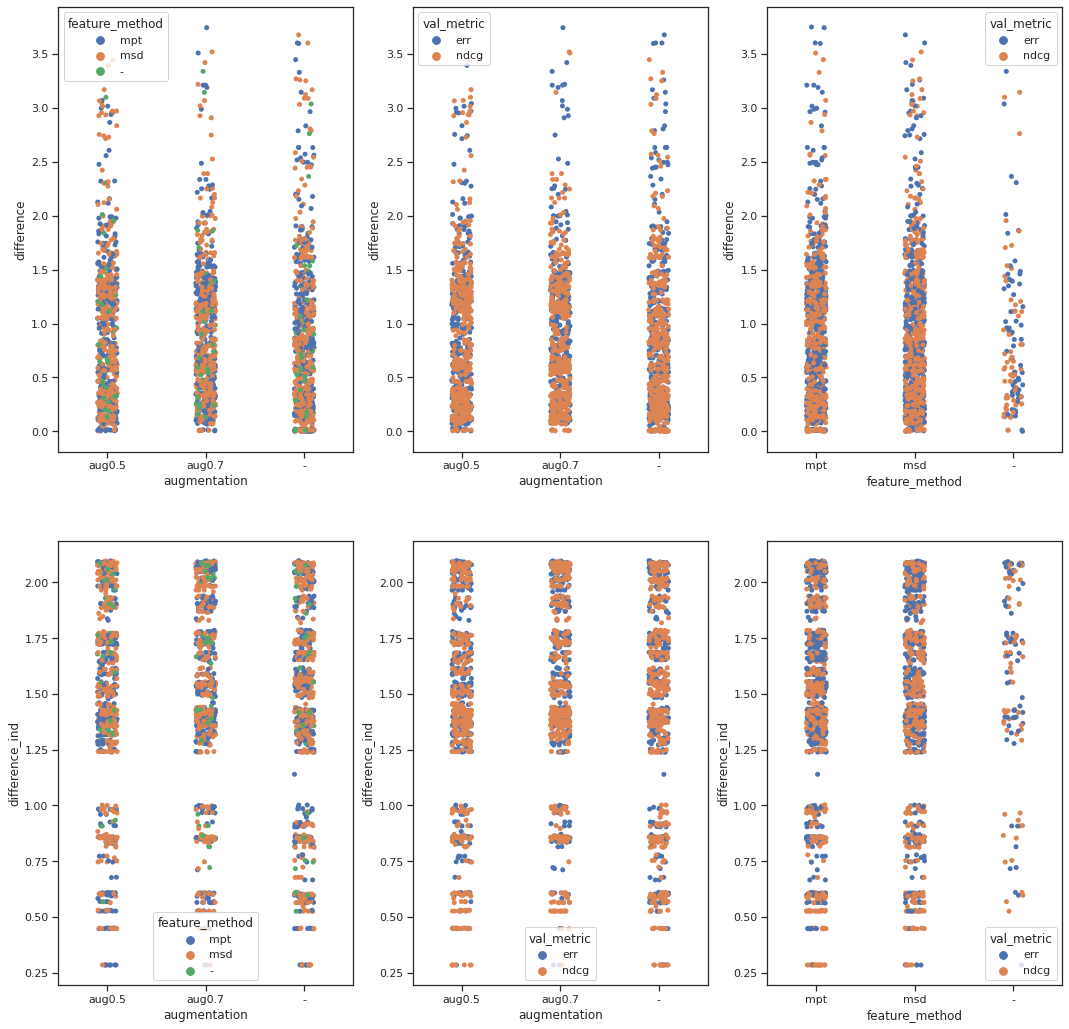

In [7]:
fig, axs = plt.subplots(2, 3, figsize=(18,18))
sns.stripplot(x='augmentation',y='difference',hue='feature_method',data=lambdata, ax=axs[0][0])
sns.stripplot(x='augmentation',y='difference',hue='val_metric',data=lambdata, ax=axs[0][1])
sns.stripplot(x='feature_method',y='difference',hue='val_metric',data=lambdata, ax=axs[0][2])

sns.stripplot(x='augmentation',y='difference_ind',hue='feature_method',data=lambdata, ax=axs[1][0])
sns.stripplot(x='augmentation',y='difference_ind',hue='val_metric',data=lambdata, ax=axs[1][1])
sns.stripplot(x='feature_method',y='difference_ind',hue='val_metric',data=lambdata, ax=axs[1][2])



#### disp_eel

<AxesSubplot:xlabel='feature_method', ylabel='disparity_ind'>

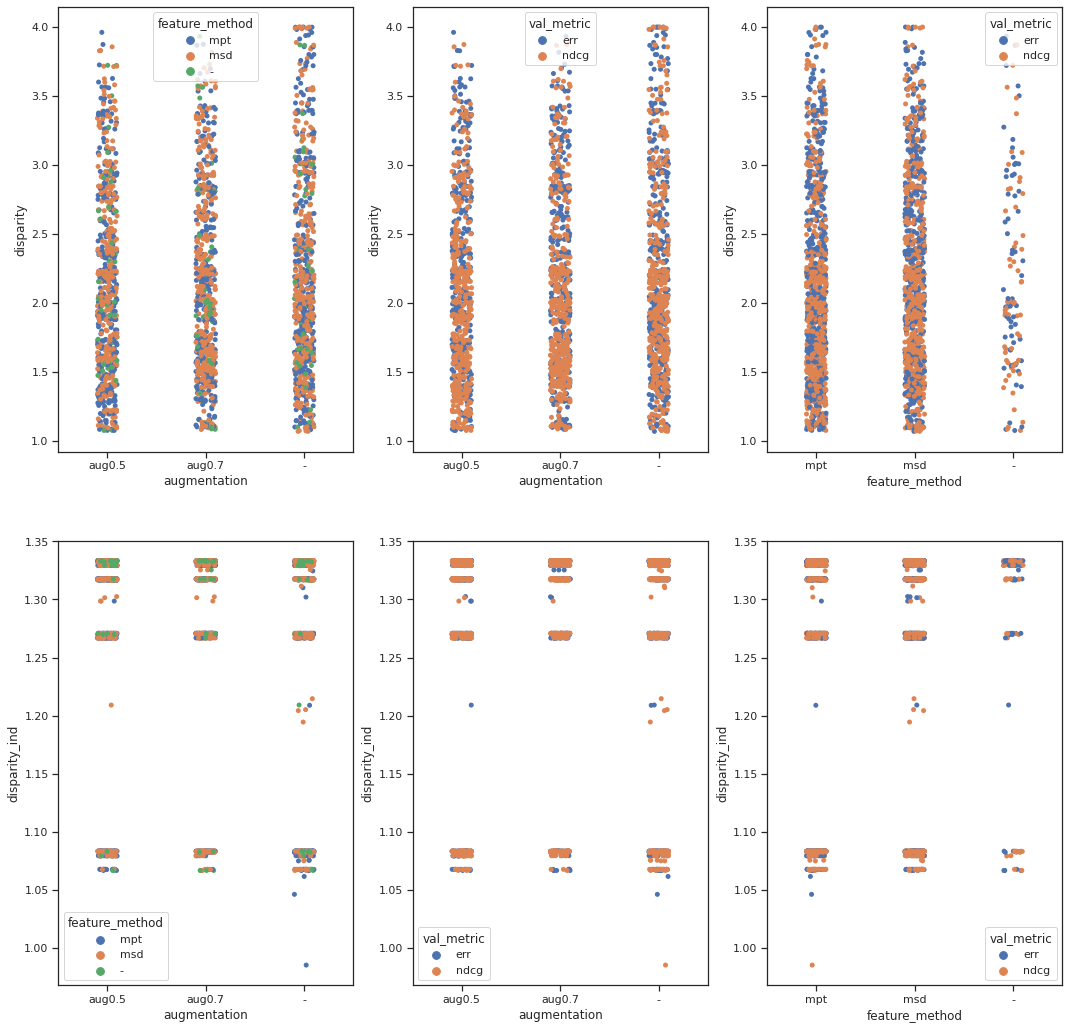

In [8]:
fig, axs = plt.subplots(2, 3, figsize=(18,18))
sns.stripplot(x='augmentation',y='disparity',hue='feature_method',data=lambdata, ax=axs[0][0])
sns.stripplot(x='augmentation',y='disparity',hue='val_metric',data=lambdata, ax=axs[0][1])
sns.stripplot(x='feature_method',y='disparity',hue='val_metric',data=lambdata, ax=axs[0][2])

sns.stripplot(x='augmentation',y='disparity_ind',hue='feature_method',data=lambdata, ax=axs[1][0])
sns.stripplot(x='augmentation',y='disparity_ind',hue='val_metric',data=lambdata, ax=axs[1][1])
sns.stripplot(x='feature_method',y='disparity_ind',hue='val_metric',data=lambdata, ax=axs[1][2])


### util

<AxesSubplot:xlabel='feature_method', ylabel='util'>

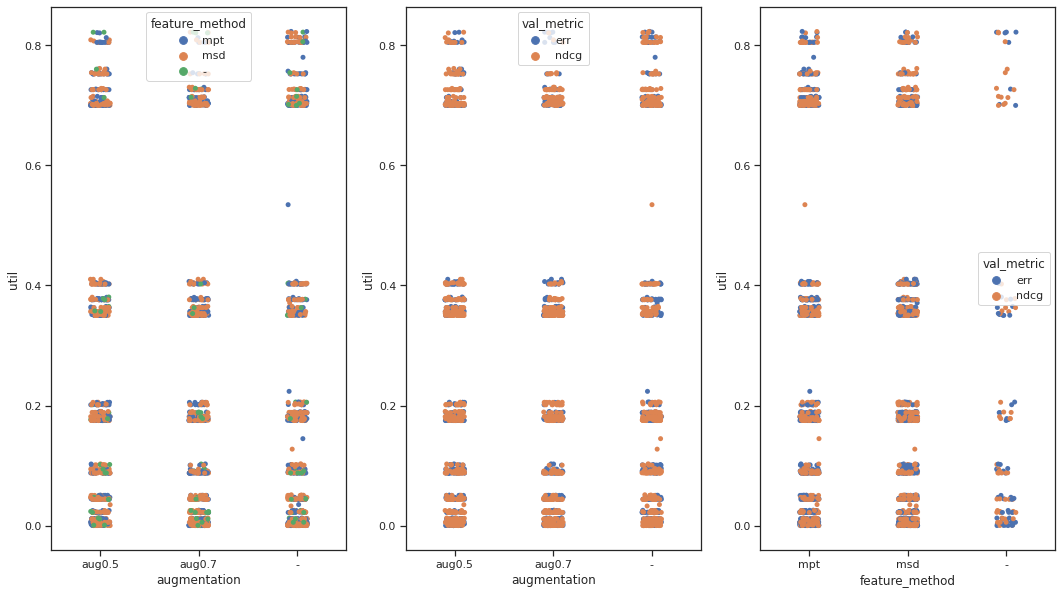

In [9]:
fig, axs = plt.subplots(1,3,figsize=(18,10))
sns.stripplot(x='augmentation',y='util',hue='feature_method',data=lambdata, ax=axs[0])
sns.stripplot(x='augmentation',y='util',hue='val_metric',data=lambdata, ax=axs[1])
sns.stripplot(x='feature_method',y='util',hue='val_metric',data=lambdata, ax=axs[2])


### Interaction plots

In [10]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt
from scipy import stats

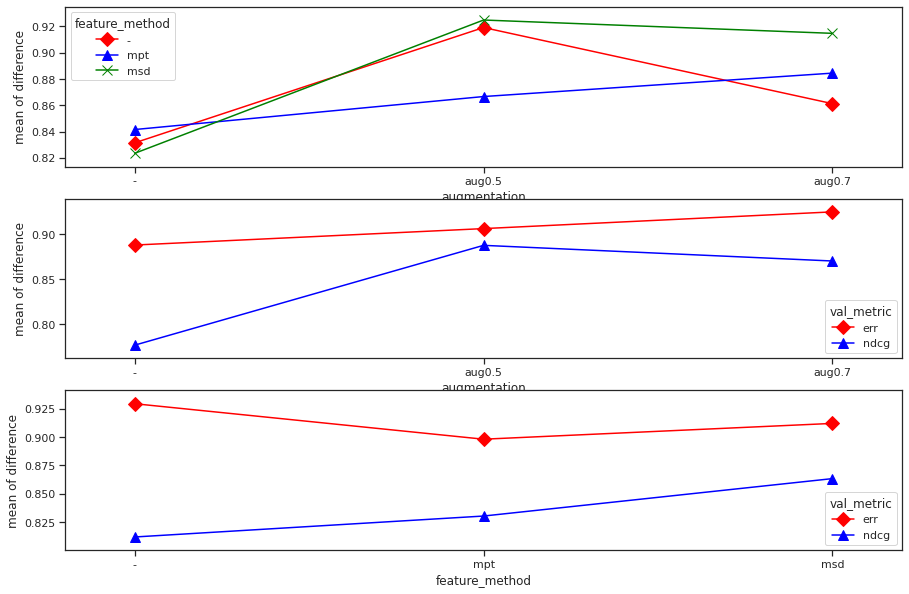

In [11]:
fig, ax = plt.subplots(3,1,figsize=(15,10))
ax[0] = interaction_plot(lambdata.augmentation, lambdata.feature_method, lambdata.difference,
             colors=['red','blue','green'], markers=['D','^','x'], ms=10, ax=ax[0])
ax[1] = interaction_plot(lambdata.augmentation, lambdata.val_metric, lambdata.difference,
             colors=['red','blue'], markers=['D','^'], ms=10, ax=ax[1])
ax[2] = interaction_plot(lambdata.feature_method, lambdata.val_metric, lambdata.difference,
             colors=['red','blue'], markers=['D','^'], ms=10, ax=ax[2])

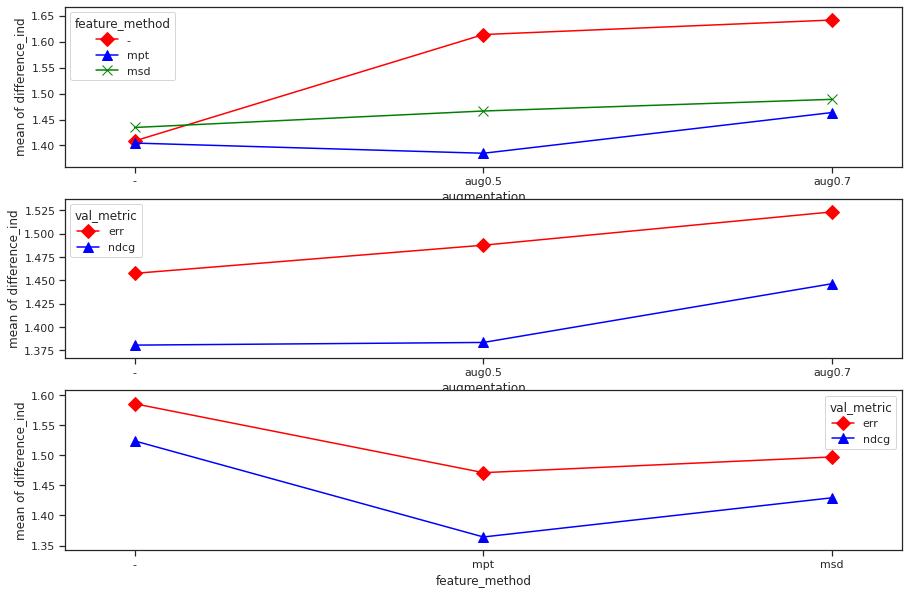

In [12]:
fig, ax = plt.subplots(3,1,figsize=(15,10))
ax[0] = interaction_plot(lambdata.augmentation, lambdata.feature_method, lambdata.difference_ind,
             colors=['red','blue','green'], markers=['D','^','x'], ms=10, ax=ax[0])
ax[1] = interaction_plot(lambdata.augmentation, lambdata.val_metric, lambdata.difference_ind,
             colors=['red','blue'], markers=['D','^'], ms=10, ax=ax[1])
ax[2] = interaction_plot(lambdata.feature_method, lambdata.val_metric, lambdata.difference_ind,
             colors=['red','blue'], markers=['D','^'], ms=10, ax=ax[2])

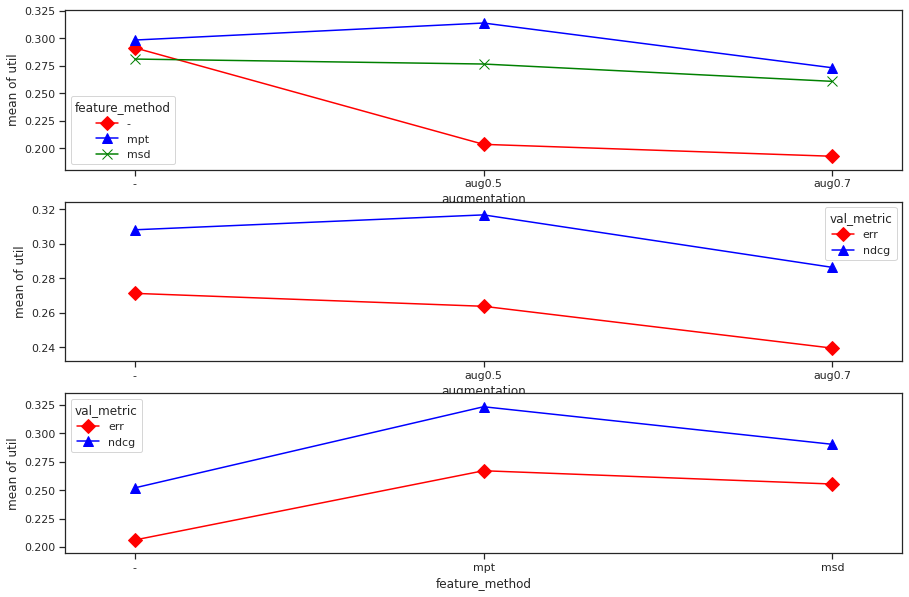

In [13]:
fig, ax = plt.subplots(3,1,figsize=(15,10))
ax[0] = interaction_plot(lambdata.augmentation, lambdata.feature_method, lambdata.util,
             colors=['red','blue','green'], markers=['D','^','x'], ms=10, ax=ax[0])
ax[1] = interaction_plot(lambdata.augmentation, lambdata.val_metric, lambdata.util,
             colors=['red','blue'], markers=['D','^'], ms=10, ax=ax[1])
ax[2] = interaction_plot(lambdata.feature_method, lambdata.val_metric, lambdata.util,
             colors=['red','blue'], markers=['D','^'], ms=10, ax=ax[2])

### ANOVA of all main factors vs EEL

We only have one replication per cell so we can't look at interactions.

In [14]:
formula = "difference ~ C(augmentation) + C(feature_method) + C(val_metric) + C(qid)"
lm = ols(formula, lambdata).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             difference   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     59.87
Date:                Tue, 31 May 2022   Prob (F-statistic):          1.21e-220
Time:                        15:48:10   Log-Likelihood:                -1837.0
No. Observations:                2280   AIC:                             3724.
Df Residuals:                    2255   BIC:                             3867.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.5245      0.073      7.182      0.000       0.381       0.668
C(augmentation)[T.aug0.5]     0.0645      0.028      2.309      0.021       0.010       0.119
C(augmentation)[T.aug0.7]     0.0651      0.028      2.330      0.020       0.010       0.120
C(feature_method)[T.mpt]     -0.0064      0.052     -0.122      0.903      -0.109       0.096
C(feature_method)[T.msd]      0.0171      0.052      0.326      0.745      -0.086       0.120
C(val_metric)[T.ndcg]        -0.0614      0.023     -2.692      0.007      -0.106      -0.017
C(qid)[T.8940]                0.7002      0.072      9.707      0.000       0.559       0.842
C(qid)[T.10795]               0.1404      0.072      1.947      0.052      -0.001       0.282
C(qid)[T.12073]               0.2469      0.072      3.422      0.001       0.105       0.388
C(qid)[T.12096]               0.1234      0.072      1.710      0.087      -0.018       0.265
C(qid)[T.12828]               0.1185      0.072      1.643      0.101      -0.023       0.260
C(qid)[T.20363]               1.3441      0.072     18.634      0.000       1.203       1.486
C(qid)[T.25869]               0.3716      0.072      5.151      0.000       0.230       0.513
C(qid)[T.27887]               0.5644      0.072      7.824      0.000       0.423       0.706
C(qid)[T.30631]               0.8153      0.072     11.303      0.000       0.674       0.957
C(qid)[T.31412]               0.8974      0.072     12.442      0.000       0.756       1.039
C(qid)[T.43018]               0.7473      0.072     10.360      0.000       0.606       0.889
C(qid)[T.49766]               0.2345      0.072      3.252      0.001       0.093       0.376
C(qid)[T.51432]               0.5241      0.072      7.266      0.000       0.383       0.666
C(qid)[T.54003]              -0.3651      0.072     -5.062      0.000      -0.507      -0.224
C(qid)[T.64062]              -0.1197      0.072     -1.659      0.097      -0.261       0.022
C(qid)[T.66637]              -0.3793      0.072     -5.259      0.000      -0.521      -0.238
C(qid)[T.67404]               0.5647      0.072      7.829      0.000       0.423       0.706
C(qid)[T.70673]               0.2751      0.072      3.814      0.000       0.134       0.417
C(qid)[T.120668]             -0.1306      0.072     -1.811      0.070      -0.272       0.011
==============================================================================
Omnibus:                      275.836   Durbin-Watson:                   1.901
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              749.819
Skew:                           0.657   Prob(JB):                    1.51e-163
Kurtosis:                       5.483   Cond. No.                         29.1
========================================================

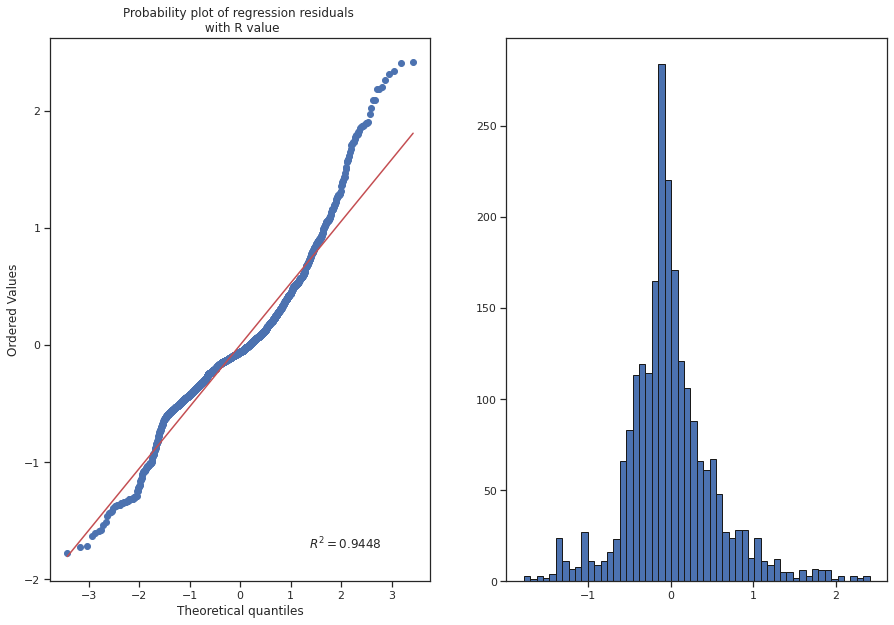

In [15]:
import pandas as pd
import scipy.stats as stats
import statsmodels.formula.api as smf


fig = plt.figure(figsize= (15, 10))
ax = fig.add_subplot(121)


normality_plot, stat = stats.probplot(lm.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of regression residuals \n with R value")
ax.set

ax2 = fig.add_subplot(122)
plt.hist(lm.resid, bins='auto', histtype='bar', ec='k') 

plt.show()

In [16]:
sm.stats.anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(augmentation),2.0,2.127160,1.063580,3.586191,2.786176e-02
C(feature_method),2.0,0.300803,0.150401,0.507125,6.022929e-01
C(val_metric),1.0,2.149023,2.149023,7.246102,7.158022e-03
C(qid),19.0,421.601454,22.189550,74.818995,1.038710e-222
Residual,2255.0,668.779845,0.296576,NaN,NaN


The influence of augmentation (0.02786 < 0.05 = p) and val_metric (0.00716 < 0.05 = p) and qid (0.00000 < 0.05) are significant

#### Tukey

In [17]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=lambdata['difference'], groups=lambdata['augmentation'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     - aug0.5   0.0645 0.1651 -0.0188 0.1478  False
     - aug0.7   0.0651 0.1598 -0.0183 0.1484  False
aug0.5 aug0.7   0.0006    0.9 -0.0828 0.0839  False
---------------------------------------------------


In [18]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=lambdata['difference'], groups=lambdata['val_metric'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   err   ndcg  -0.0614 0.0344 -0.1183 -0.0045   True
----------------------------------------------------


In [19]:
lambdata.groupby('augmentation')['difference'].describe()

,count,mean,std,min,25%,50%,75%,max
augmentation,,,,,,,,
-,760.0,0.832533,0.731852,0.000207,0.247127,0.678176,1.204421,3.677112
aug0.5,760.0,0.897032,0.696236,0.003692,0.318219,0.750536,1.336612,3.749589
aug0.7,760.0,0.897620,0.647672,0.004736,0.352708,0.764432,1.278098,3.743701


In [20]:
lambdata.groupby('val_metric')['difference'].describe()

,count,mean,std,min,25%,50%,75%,max
val_metric,,,,,,,,
err,1140.0,0.906429,0.717295,0.000207,0.324802,0.763359,1.311947,3.749589
ndcg,1140.0,0.845027,0.667034,0.000222,0.307751,0.686132,1.270179,3.519270


The base config of LambdaMart performs best in terms of group difference.

### ANOVA of all main factors vs EEL_ind

We only have one replication per cell so we can't look at interactions.

In [21]:
formula = "difference_ind ~ C(augmentation) + C(feature_method) + C(val_metric) + C(qid)"
lm = ols(formula, lambdata).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         difference_ind   R-squared:                       0.375
Model:                            OLS   Adj. R-squared:                  0.368
Method:                 Least Squares   F-statistic:                     56.31
Date:                Tue, 31 May 2022   Prob (F-statistic):          2.40e-209
Time:                        15:48:11   Log-Likelihood:                -928.66
No. Observations:                2280   AIC:                             1907.
Df Residuals:                    2255   BIC:                             2051.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     1.6152      0.049     32.943      0.000       1.519       1.711
C(augmentation)[T.aug0.5]     0.0165      0.019      0.881      0.378      -0.020       0.053
C(augmentation)[T.aug0.7]     0.0659      0.019      3.511      0.000       0.029       0.103
C(feature_method)[T.mpt]     -0.1371      0.035     -3.896      0.000      -0.206      -0.068
C(feature_method)[T.msd]     -0.0914      0.035     -2.599      0.009      -0.160      -0.022
C(val_metric)[T.ndcg]        -0.0860      0.015     -5.616      0.000      -0.116      -0.056
C(qid)[T.8940]                0.2550      0.048      5.264      0.000       0.160       0.350
C(qid)[T.10795]               0.0646      0.048      1.335      0.182      -0.030       0.160
C(qid)[T.12073]              -0.3665      0.048     -7.568      0.000      -0.461      -0.272
C(qid)[T.12096]               0.3892      0.048      8.036      0.000       0.294       0.484
C(qid)[T.12828]              -0.4455      0.048     -9.200      0.000      -0.541      -0.351
C(qid)[T.20363]               0.0262      0.048      0.541      0.589      -0.069       0.121
C(qid)[T.25869]              -0.2789      0.048     -5.758      0.000      -0.374      -0.184
C(qid)[T.27887]              -0.0758      0.048     -1.564      0.118      -0.171       0.019
C(qid)[T.30631]               0.4965      0.048     10.252      0.000       0.402       0.591
C(qid)[T.31412]              -0.2310      0.048     -4.769      0.000      -0.326      -0.136
C(qid)[T.43018]               0.4880      0.048     10.077      0.000       0.393       0.583
C(qid)[T.49766]              -0.2142      0.048     -4.423      0.000      -0.309      -0.119
C(qid)[T.51432]               0.0009      0.048      0.019      0.985      -0.094       0.096
C(qid)[T.54003]              -0.0994      0.048     -2.052      0.040      -0.194      -0.004
C(qid)[T.64062]              -0.4817      0.048     -9.946      0.000      -0.577      -0.387
C(qid)[T.66637]              -0.2248      0.048     -4.641      0.000      -0.320      -0.130
C(qid)[T.67404]              -0.0826      0.048     -1.706      0.088      -0.178       0.012
C(qid)[T.70673]               0.0453      0.048      0.935      0.350      -0.050       0.140
C(qid)[T.120668]             -0.1638      0.048     -3.383      0.001      -0.259      -0.069
==============================================================================
Omnibus:                      291.123   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              471.532
Skew:                          -0.873   Prob(JB):                    4.06e-103
Kurtosis:                       4.383   Cond. No.                         29.1
========================================================

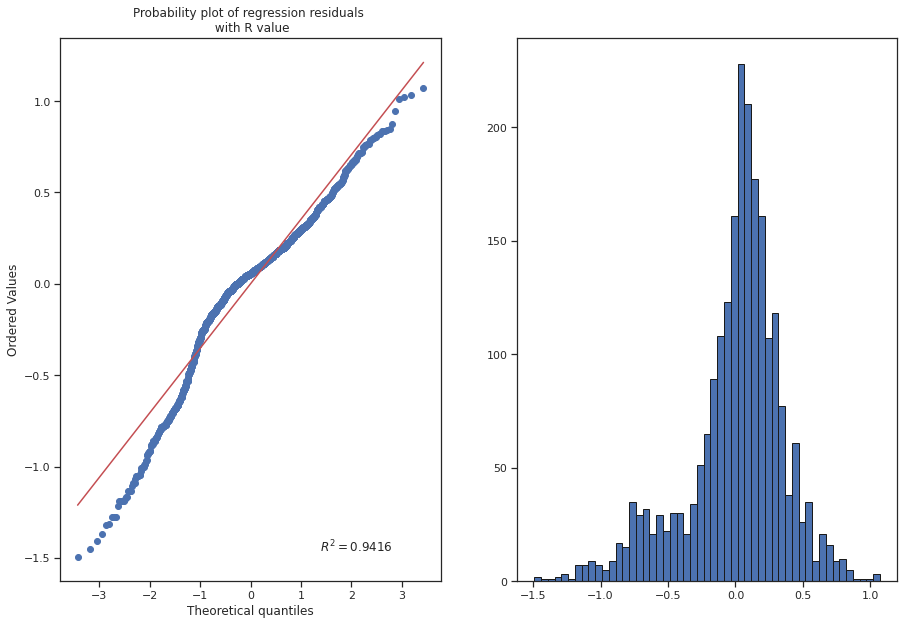

In [22]:
import pandas as pd
import scipy.stats as stats
import statsmodels.formula.api as smf


fig = plt.figure(figsize= (15, 10))
ax = fig.add_subplot(121)


normality_plot, stat = stats.probplot(lm.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of regression residuals \n with R value")
ax.set

ax2 = fig.add_subplot(122)
plt.hist(lm.resid, bins='auto', histtype='bar', ec='k') 

plt.show()

In [23]:
sm.stats.anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(augmentation),2.0,1.784475,0.892238,6.673977,1.288467e-03
C(feature_method),2.0,2.608835,1.304417,9.757100,6.036361e-05
C(val_metric),1.0,4.217105,4.217105,31.544137,2.189707e-08
C(qid),19.0,172.063595,9.055979,67.739126,1.095256e-204
Residual,2255.0,301.468781,0.133689,NaN,NaN


All factors are significant for the individual fairness.

#### Tukey

In [24]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=lambdata['difference_ind'], groups=lambdata['augmentation'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     - aug0.5   0.0165 0.7424 -0.0387 0.0718  False
     - aug0.7   0.0659 0.0145  0.0106 0.1211   True
aug0.5 aug0.7   0.0493 0.0913 -0.0059 0.1046  False
---------------------------------------------------


In [25]:
lambdata.groupby('augmentation')['difference_ind'].describe()

,count,mean,std,min,25%,50%,75%,max
augmentation,,,,,,,,
-,760.0,1.419060,0.490119,0.284607,1.105301,1.492940,1.772493,2.097133
aug0.5,760.0,1.435584,0.453438,0.284899,1.259942,1.426897,1.753008,2.096680
aug0.7,760.0,1.484917,0.432505,0.284899,1.319873,1.494828,1.846646,2.096680


In [26]:
lambdata.groupby('val_metric')['difference_ind'].describe()

,count,mean,std,min,25%,50%,75%,max
val_metric,,,,,,,,
err,1140.0,1.489527,0.438333,0.284729,1.315510,1.524986,1.844715,2.097133
ndcg,1140.0,1.403513,0.476934,0.284607,0.997698,1.426865,1.746147,2.094867


The base config of LambdaMart performs best in terms of individual difference.

### ANOVA of all main factors vs utility

We only have one replication per cell so we can't look at interactions.

In [27]:
formula = "util ~ C(augmentation) + C(feature_method) + C(val_metric) + C(qid)"
lm = ols(formula, lambdata).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   util   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     61.04
Date:                Tue, 31 May 2022   Prob (F-statistic):          2.68e-224
Time:                        15:48:11   Log-Likelihood:                 328.38
No. Observations:                2280   AIC:                            -606.8
Df Residuals:                    2255   BIC:                            -463.5
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.1704      0.028      6.031      0.000       0.115       0.226
C(augmentation)[T.aug0.5]     0.0006      0.011      0.053      0.957      -0.021       0.022
C(augmentation)[T.aug0.7]    -0.0268      0.011     -2.476      0.013      -0.048      -0.006
C(feature_method)[T.mpt]      0.0660      0.020      3.257      0.001       0.026       0.106
C(feature_method)[T.msd]      0.0437      0.020      2.155      0.031       0.004       0.083
C(val_metric)[T.ndcg]         0.0456      0.009      5.162      0.000       0.028       0.063
C(qid)[T.8940]               -0.0751      0.028     -2.692      0.007      -0.130      -0.020
C(qid)[T.10795]              -0.0939      0.028     -3.367      0.001      -0.149      -0.039
C(qid)[T.12073]               0.3139      0.028     11.249      0.000       0.259       0.369
C(qid)[T.12096]              -0.1308      0.028     -4.689      0.000      -0.186      -0.076
C(qid)[T.12828]               0.2533      0.028      9.077      0.000       0.199       0.308
C(qid)[T.20363]               0.0195      0.028      0.700      0.484      -0.035       0.074
C(qid)[T.25869]               0.2124      0.028      7.612      0.000       0.158       0.267
C(qid)[T.27887]              -0.2099      0.028     -7.521      0.000      -0.265      -0.155
C(qid)[T.30631]              -0.1850      0.028     -6.629      0.000      -0.240      -0.130
C(qid)[T.31412]               0.1624      0.028      5.818      0.000       0.108       0.217
C(qid)[T.43018]              -0.1754      0.028     -6.285      0.000      -0.230      -0.121
C(qid)[T.49766]               0.1557      0.028      5.581      0.000       0.101       0.210
C(qid)[T.51432]              -0.1431      0.028     -5.127      0.000      -0.198      -0.088
C(qid)[T.54003]               0.0944      0.028      3.384      0.001       0.040       0.149
C(qid)[T.64062]               0.3539      0.028     12.682      0.000       0.299       0.409
C(qid)[T.66637]               0.1550      0.028      5.553      0.000       0.100       0.210
C(qid)[T.67404]               0.0900      0.028      3.226      0.001       0.035       0.145
C(qid)[T.70673]               0.0310      0.028      1.109      0.267      -0.024       0.086
C(qid)[T.120668]              0.0653      0.028      2.341      0.019       0.011       0.120
==============================================================================
Omnibus:                      100.157   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.698
Skew:                           0.527   Prob(JB):                     3.37e-25
Kurtosis:                       3.277   Cond. No.                         29.1
========================================================

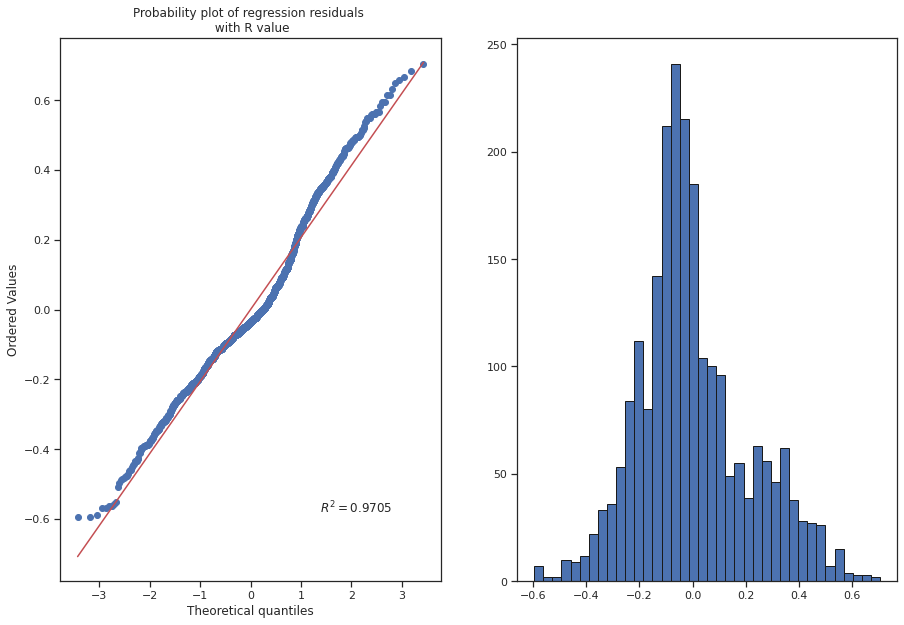

In [28]:
import pandas as pd
import scipy.stats as stats
import statsmodels.formula.api as smf


fig = plt.figure(figsize= (15, 10))
ax = fig.add_subplot(121)


normality_plot, stat = stats.probplot(lm.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of regression residuals \n with R value")
ax.set

ax2 = fig.add_subplot(122)
plt.hist(lm.resid, bins='auto', histtype='bar', ec='k') 

plt.show()

In [29]:
sm.stats.anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(augmentation),2.0,0.370749,0.185374,4.176706,1.546789e-02
C(feature_method),2.0,0.611425,0.305712,6.888067,1.041480e-03
C(val_metric),1.0,1.182682,1.182682,26.647237,2.655712e-07
C(qid),19.0,62.859311,3.308385,74.541888,5.126686e-222
Residual,2255.0,100.083427,0.044383,NaN,NaN


All factors are significant for the utility.

#### Tukey

In [30]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=lambdata['util'], groups=lambdata['augmentation'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     - aug0.5   0.0006    0.9 -0.0318 0.0329  False
     - aug0.7  -0.0268  0.128 -0.0591 0.0056  False
aug0.5 aug0.7  -0.0273 0.1173 -0.0597  0.005  False
---------------------------------------------------


In [31]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=lambdata['util'], groups=lambdata['feature_method'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     -    mpt    0.066  0.029  0.0054 0.1267   True
     -    msd   0.0437 0.2098  -0.017 0.1043  False
   mpt    msd  -0.0223 0.1302 -0.0495 0.0048  False
---------------------------------------------------


In [32]:
lambdata.groupby('augmentation')['util'].describe()

,count,mean,std,min,25%,50%,75%,max
augmentation,,,,,,,,
-,760.0,0.289805,0.284054,0.000001,0.043750,0.181465,0.438995,0.823303
aug0.5,760.0,0.290381,0.264611,0.000005,0.047031,0.188127,0.402500,0.821955
aug0.7,760.0,0.263047,0.257564,0.000001,0.043750,0.178348,0.376250,0.822122


In [33]:
lambdata.groupby('feature_method')['util'].describe()

,count,mean,std,min,25%,50%,75%,max
feature_method,,,,,,,,
-,120.0,0.229111,0.272739,0.000043,0.021901,0.090812,0.363125,0.822122
mpt,1080.0,0.295132,0.268951,0.000001,0.044570,0.188376,0.402715,0.823303
msd,1080.0,0.272798,0.268168,0.000001,0.043752,0.178347,0.402500,0.822110


In [34]:
lambdata.groupby('val_metric')['util'].describe()

,count,mean,std,min,25%,50%,75%,max
val_metric,,,,,,,,
err,1140.0,0.258303,0.260609,0.000001,0.025384,0.176641,0.377237,0.823303
ndcg,1140.0,0.303853,0.275687,0.000001,0.044190,0.189147,0.700001,0.823125


NDCG, mpt, and aug0.5 yield the best utility results

In [35]:
lambdata.sort_values(by='util',ascending=False)

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,util,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor
1563,0.332922,1.080384,0.704310,0.905783,1.066670,0.161252,0.823303,12073,lambdamart,-,-,-,-,-,-,err,mpt,10,0.9
1923,0.340676,1.099428,0.709954,0.906279,1.066671,0.161004,0.823125,12073,lambdamart,-,-,-,-,-,-,ndcg,mpt,10,0.5
1123,0.431735,1.083141,0.656281,0.907721,1.066716,0.160305,0.822122,12073,lambdamart,-,-,-,-,-,aug0.7,err,-,-,-
1743,0.913633,1.068364,0.407944,0.907773,1.066716,0.160279,0.822110,12073,lambdamart,-,-,-,-,-,-,err,msd,10,0.9
1892,0.852561,1.100476,0.443846,0.717047,1.066716,0.352265,0.822108,49766,lambdamart,-,-,-,-,-,-,err,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,0.960913,2.040636,0.891970,1.426899,1.333333,0.000001,0.000006,27887,lambdamart,-,-,-,-,-,aug0.5,err,msd,15,0.9
608,0.887308,2.902082,1.359496,1.426900,1.333333,0.000001,0.000005,27887,lambdamart,-,-,-,-,-,aug0.5,ndcg,msd,10,0.9
1048,1.067281,3.196389,1.416662,1.426900,1.333333,0.000000,0.000003,27887,lambdamart,-,-,-,-,-,aug0.7,err,msd,15,0.9
988,0.975820,3.050108,1.389253,1.426900,1.333333,0.000000,0.000001,27887,lambdamart,-,-,-,-,-,aug0.7,err,msd,10,0.9


In [36]:
lambdata.sort_values(by='difference',ascending=True)

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,util,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor
1790,0.000207,1.577612,1.583280,0.285539,1.067708,0.782169,0.805000,31412,lambdamart,-,-,-,-,-,-,err,msd,15,0.5
2054,0.000222,1.884926,1.870484,0.284899,1.067708,0.782809,0.805000,54003,lambdamart,-,-,-,-,-,-,ndcg,mpt,20,0.5
2074,0.000222,1.884926,1.870484,0.284899,1.067708,0.782809,0.805000,54003,lambdamart,-,-,-,-,-,-,ndcg,mpt,20,0.9
1936,0.000284,1.884591,1.868266,0.284729,1.067708,0.782979,0.805000,66637,lambdamart,-,-,-,-,-,-,ndcg,mpt,10,0.5
1896,0.000284,1.884591,1.868266,0.284729,1.067708,0.782979,0.805000,66637,lambdamart,-,-,-,-,-,-,err,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1811,3.601599,3.093844,0.158770,2.087608,1.333318,0.013759,0.005469,43018,lambdamart,-,-,-,-,-,-,err,msd,15,0.9
1630,3.602409,2.324882,0.155814,2.065644,1.333272,0.024899,0.011348,31412,lambdamart,-,-,-,-,-,-,err,mpt,15,0.9
1846,3.677112,3.100775,0.198738,1.835511,1.332341,0.035557,0.047523,20363,lambdamart,-,-,-,-,-,-,err,msd,20,0.5
770,3.743701,2.455980,0.150717,2.074083,1.333317,0.020702,0.006289,31412,lambdamart,-,-,-,-,-,aug0.7,err,mpt,10,0.1


In [37]:
lambdata.sort_values(by='difference_ind',ascending=True)

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,util,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor
2016,0.000332,1.887271,1.869582,0.284607,1.067587,0.782979,0.805000,66637,lambdamart,-,-,-,-,-,-,ndcg,mpt,15,0.9
2177,0.002704,1.813947,1.758967,0.284729,1.067708,0.782979,0.805000,67404,lambdamart,-,-,-,-,-,-,ndcg,msd,15,0.5
1896,0.000284,1.884591,1.868266,0.284729,1.067708,0.782979,0.805000,66637,lambdamart,-,-,-,-,-,-,err,-,-,-
1936,0.000284,1.884591,1.868266,0.284729,1.067708,0.782979,0.805000,66637,lambdamart,-,-,-,-,-,-,ndcg,mpt,10,0.5
2054,0.000222,1.884926,1.870484,0.284899,1.067708,0.782809,0.805000,54003,lambdamart,-,-,-,-,-,-,ndcg,mpt,20,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831,1.275393,1.450724,0.500313,2.096076,1.333333,0.009532,0.000684,43018,lambdamart,-,-,-,-,-,aug0.7,err,mpt,15,0.1
1591,2.197900,1.756147,0.191771,2.096076,1.333333,0.009532,0.000684,43018,lambdamart,-,-,-,-,-,-,err,mpt,15,0.1
811,2.485976,2.039072,0.189195,2.096680,1.333333,0.009230,0.000342,43018,lambdamart,-,-,-,-,-,aug0.7,err,mpt,10,0.9
131,0.736521,1.497910,0.793342,2.096680,1.333333,0.009230,0.000342,43018,lambdamart,-,-,-,-,-,aug0.5,err,mpt,20,0.1


# Big ranker comp

Since the base LM config (NDCG, no augmentation, no feature selection) yields the highest fairness both for group and individual fairness, we use it as the base configuration for re-ranking.

Now we see if re-ranking significantly improves the eel and eel ind.

### ANOVA without replication main factors

In [38]:
pipeline = experiments[(experiments.augmentation == '-') & (experiments.ranker != 'relevance_ranker') & ((experiments.source == 'lambdamart_ndcg_noaug_nofeat') | (experiments.source == 'lambdamart_noaug_ndcg_nofeat') | (experiments.source == 'META_train') | (experiments.source == 'TEXT_train') | ((experiments.source == '-') & (experiments.ranker == 'lambdamart') & (experiments.val_metric == 'ndcg') & (experiments.feature_method == '-')))]
pipeline.source = pipeline.source.apply(lambda row: 'KR' if '_train' in row else 'lambdamart' if 'lambdamart' in row else '-')
pipeline = pipeline.reset_index(drop=True)
pipeline

/home/pilmus/thesis/venv37/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,util,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor
0,0.182191,1.980651,1.455915,0.437331,0.170282,0.086966,0.179057,3462,ac,lambdamart,auth,ind,99.0,linear,-,-,-,-,-
1,1.041090,2.171230,1.010655,0.816026,0.448635,0.207794,0.206360,8940,ac,lambdamart,auth,ind,99.0,linear,-,-,-,-,-
2,0.414444,1.583612,1.189284,0.454495,0.250329,0.075348,0.195310,10795,ac,lambdamart,auth,ind,99.0,linear,-,-,-,-,-
3,0.039438,0.827501,0.724610,0.108136,0.129017,0.091249,0.496302,12073,ac,lambdamart,auth,ind,99.0,linear,-,-,-,-,-
4,0.299488,1.349268,1.391169,0.853557,0.352509,0.140512,0.144921,12096,ac,lambdamart,auth,ind,99.0,linear,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1695,0.402150,2.441503,1.577406,0.374586,0.257188,0.161792,0.322741,64062,rfr,KR,doc,-,-,-,-,-,-,-,-
1696,0.150777,3.059053,2.380250,0.609978,0.483562,0.328282,0.330261,66637,rfr,KR,doc,-,-,-,-,-,-,-,-
1697,0.050436,1.884897,1.770575,0.495148,0.495443,0.391637,0.411824,67404,rfr,KR,doc,-,-,-,-,-,-,-,-
1698,0.251974,1.613103,1.143375,0.819353,0.290380,0.126659,0.121662,70673,rfr,KR,doc,-,-,-,-,-,-,-,-


In [39]:
from collections import Counter
Counter(zip(pipeline.ranker.to_list(),pipeline.source.to_list()))

Counter({('ac', 'lambdamart'): 480,
         ('ac', 'KR'): 960,
         ('lambdamart', '-'): 20,
         ('rfr', 'lambdamart'): 80,
         ('rfr', 'KR'): 160})

In [40]:
formula = "difference ~ C(ranker)"
lm = ols(formula, pipeline).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             difference   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     5.455
Date:                Tue, 31 May 2022   Prob (F-statistic):            0.00435
Time:                        15:48:12   Log-Likelihood:                -1507.8
No. Observations:                1700   AIC:                             3022.
Df Residuals:                    1697   BIC:                             3038.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.4446      0.015     28.695      0.000       0.414       0.475
C(ranker)[T.lambdamart]     0.3173      0.132      2.397      0.017       0.058       0.577
C(ranker)[T.rfr]            0.0974      0.041      2.376      0.018       0.017       0.178
==============================================================================
Omnibus:                     1292.283   Durbin-Watson:                   1.377
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23783.436
Skew:                           3.474   Prob(JB):                         0.00
Kurtosis:                      19.956   Cond. No.                         9.39
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

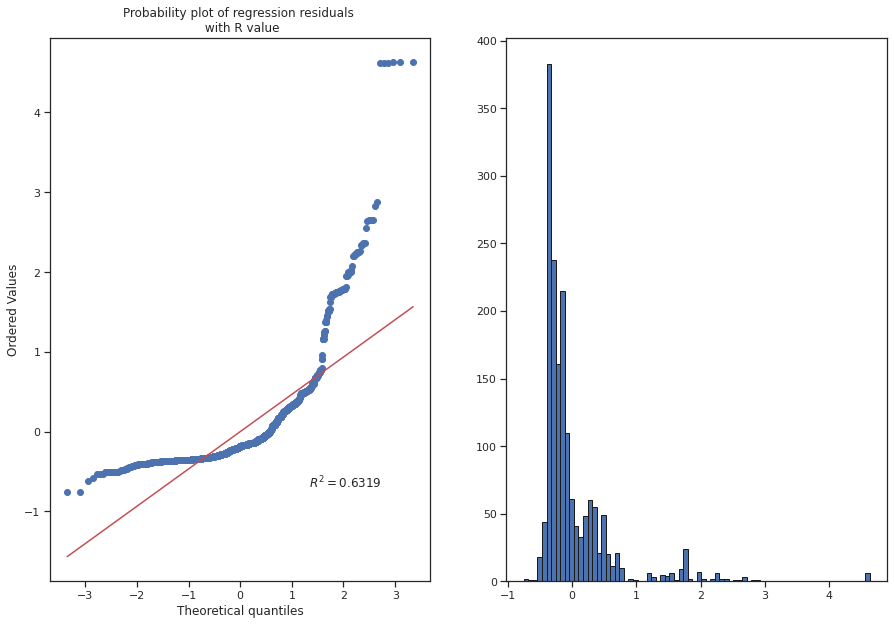

In [41]:
import pandas as pd
import scipy.stats as stats
import statsmodels.formula.api as smf


fig = plt.figure(figsize= (15, 10))
ax = fig.add_subplot(121)


normality_plot, stat = stats.probplot(lm.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of regression residuals \n with R value")
ax.set

ax2 = fig.add_subplot(122)
plt.hist(lm.resid, bins='auto', histtype='bar', ec='k') 

plt.show()

In [42]:
sm.stats.anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(ranker),2.0,3.771426,1.885713,5.455097,0.00435
Residual,1697.0,586.617441,0.345679,NaN,NaN


The ranker matters for the difference.

#### Tukey

In [43]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=pipeline['difference'], groups=pipeline['ranker'], alpha=0.05)
print(tukey)


    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1     group2   meandiff p-adj   lower  upper  reject
-----------------------------------------------------------
        ac lambdamart   0.3173 0.0439  0.0068 0.6279   True
        ac        rfr   0.0974 0.0463  0.0012 0.1936   True
lambdamart        rfr  -0.2199 0.2431 -0.5409 0.1011  False
-----------------------------------------------------------


In [44]:
pipeline.groupby('ranker')['difference'].describe()

,count,mean,std,min,25%,50%,75%,max
ranker,,,,,,,,
ac,1440.0,0.444588,0.520844,0.038473,0.120882,0.271485,0.560439,3.327600
lambdamart,20.0,0.761915,0.664219,0.010388,0.360119,0.584513,0.973409,2.761008
rfr,240.0,0.541997,0.886591,0.011347,0.159663,0.260910,0.585954,5.169599


RFR and AC have better difference than lambdamart, but only for AC the group difference is significant.

#### Tukey

In [45]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=pipeline['difference_ind'], groups=pipeline['ranker'], alpha=0.05)
print(tukey)


    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1     group2   meandiff p-adj  lower   upper  reject
-----------------------------------------------------------
        ac lambdamart    0.892 0.001  0.7438  1.0403   True
        ac        rfr   0.1856 0.001  0.1397  0.2315   True
lambdamart        rfr  -0.7065 0.001 -0.8597 -0.5532   True
-----------------------------------------------------------


In [46]:
pipeline.groupby('ranker')['difference_ind'].describe()

,count,mean,std,min,25%,50%,75%,max
ranker,,,,,,,,
ac,1440.0,0.485732,0.242993,0.066934,0.299693,0.499918,0.680049,1.488943
lambdamart,20.0,1.377774,0.538589,0.525955,0.829032,1.484980,1.796156,2.078018
rfr,240.0,0.671313,0.425435,0.096757,0.348338,0.588603,0.883523,1.629713


RFR and AC have better difference than lambdamart, for all pairwise combos the difference is significant.

#### Tukey

In [47]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=pipeline['util'], groups=pipeline['ranker'], alpha=0.05)
print(tukey)


    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2   meandiff p-adj   lower   upper  reject
------------------------------------------------------------
        ac lambdamart   0.0679 0.0321  0.0046  0.1312   True
        ac        rfr  -0.0018    0.9 -0.0214  0.0178  False
lambdamart        rfr  -0.0696 0.0338 -0.1351 -0.0042   True
------------------------------------------------------------


In [48]:
pipeline.groupby('ranker')['util'].describe()

,count,mean,std,min,25%,50%,75%,max
ranker,,,,,,,,
ac,1440.0,0.249155,0.102265,0.051430,0.175162,0.235637,0.301695,0.639813
lambdamart,20.0,0.317033,0.321742,0.005482,0.044368,0.134531,0.702112,0.806143
rfr,240.0,0.247398,0.175543,0.000071,0.126904,0.234316,0.327418,0.673985


RFR and AC have better difference than lambdamart, but only for AC the difference is significant.

## within AC and RFR

#### AC

In [49]:
acdata = experiments[(experiments.ranker == 'ac') & ((experiments.source == 'TEXT_train') | (experiments.source == 'META_train') | (experiments.source == 'lambdamart_noaug_ndcg_nofeat'))]
acdata.source = acdata.source.apply(lambda x: 'KR' if '_train' in x else 'lambdamart')
acdata = acdata.reset_index(drop=True)

acdata.tail()

/home/pilmus/thesis/venv37/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,util,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor
1435,0.272667,2.230380,1.536586,0.343055,0.168404,0.133166,0.271003,64062,ac,KR,doc,-,9.0,min,-,-,-,-,-
1436,0.114067,2.821265,2.279711,0.588711,0.307959,0.251114,0.254121,66637,ac,KR,doc,-,9.0,min,-,-,-,-,-
1437,0.306071,1.413757,1.407188,0.562221,0.303359,0.262059,0.267570,67404,ac,KR,doc,-,9.0,min,-,-,-,-,-
1438,0.443033,1.829159,1.155873,0.680858,0.214499,0.157966,0.159937,70673,ac,KR,doc,-,9.0,min,-,-,-,-,-
1439,0.141151,1.235171,1.106681,0.138905,0.103822,0.081223,0.366972,120668,ac,KR,doc,-,9.0,min,-,-,-,-,-


In [50]:
from collections import Counter
Counter(acdata.source.to_list())

Counter({'lambdamart': 480, 'KR': 960})

##### group diff

In [51]:
formula = 'difference ~ C(group) + C(theta) + C(hfunc) + C(source) + C(qid)'
lm = ols(formula, acdata).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             difference   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     423.9
Date:                Tue, 31 May 2022   Prob (F-statistic):               0.00
Time:                        15:48:13   Log-Likelihood:                 410.57
No. Observations:                1440   AIC:                            -771.1
Df Residuals:                    1415   BIC:                            -639.3
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.1181      0.024      5.000      0.000       0.072       0.164
C(group)[T.doc]            -0.0266      0.011     -2.382      0.017      -0.049      -0.005
C(theta)[T.99.0]           -0.0061      0.010     -0.633      0.527      -0.025       0.013
C(hfunc)[T.max]             0.0042      0.012      0.351      0.725      -0.019       0.027
C(hfunc)[T.min]             0.0157      0.012      1.329      0.184      -0.007       0.039
C(source)[T.lambdamart]    -0.0354      0.010     -3.449      0.001      -0.056      -0.015
C(qid)[T.8940]              0.4203      0.031     13.740      0.000       0.360       0.480
C(qid)[T.10795]             0.0741      0.031      2.423      0.015       0.014       0.134
C(qid)[T.12073]            -0.0001      0.031     -0.003      0.997      -0.060       0.060
C(qid)[T.12096]             0.1328      0.031      4.342      0.000       0.073       0.193
C(qid)[T.12828]            -0.0026      0.031     -0.084      0.933      -0.063       0.057
C(qid)[T.20363]             0.6098      0.031     19.933      0.000       0.550       0.670
C(qid)[T.25869]             0.5946      0.031     19.437      0.000       0.535       0.655
C(qid)[T.27887]             0.1242      0.031      4.061      0.000       0.064       0.184
C(qid)[T.30631]             0.8917      0.031     29.149      0.000       0.832       0.952
C(qid)[T.31412]             2.1452      0.031     70.125      0.000       2.085       2.205
C(qid)[T.43018]             0.7229      0.031     23.633      0.000       0.663       0.783
C(qid)[T.49766]             0.1528      0.031      4.994      0.000       0.093       0.213
C(qid)[T.51432]             0.2032      0.031      6.643      0.000       0.143       0.263
C(qid)[T.54003]             0.0291      0.031      0.950      0.342      -0.031       0.089
C(qid)[T.64062]             0.1941      0.031      6.345      0.000       0.134       0.254
C(qid)[T.66637]             0.0019      0.031      0.062      0.950      -0.058       0.062
C(qid)[T.67404]             0.1783      0.031      5.828      0.000       0.118       0.238
C(qid)[T.70673]             0.2854      0.031      9.330      0.000       0.225       0.345
C(qid)[T.120668]            0.0702      0.031      2.296      0.022       0.010       0.130
==============================================================================
Omnibus:                      694.798   Durbin-Watson:                   1.501
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9060.188
Skew:                           1.909   Prob(JB):                         0.00
Kurtosis:                      14.680   Cond. No.                         27.3
==============================================================================

Notes:
[1] Standard Errors assum

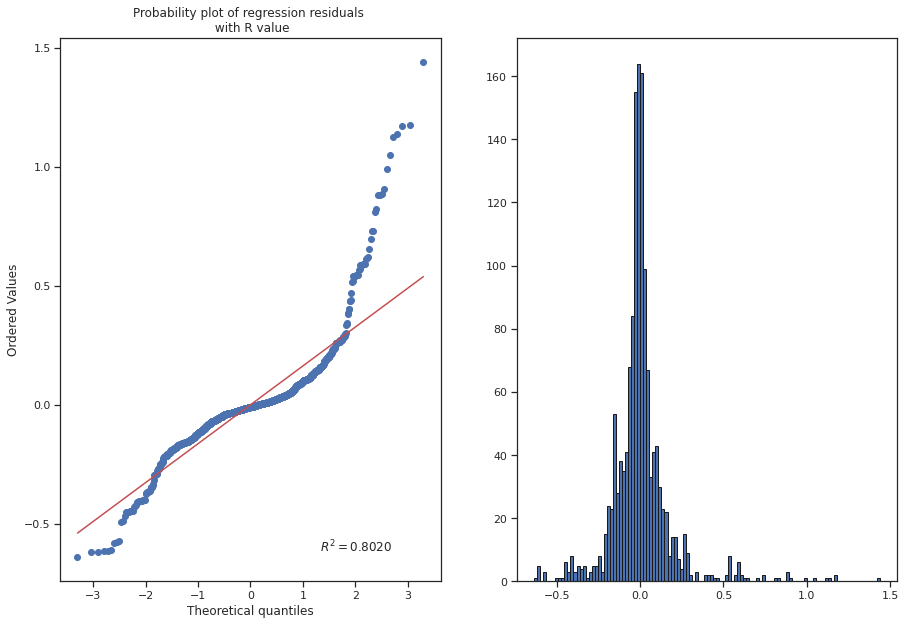

In [52]:
import pandas as pd
import scipy.stats as stats
import statsmodels.formula.api as smf


fig = plt.figure(figsize= (15, 10))
ax = fig.add_subplot(121)


normality_plot, stat = stats.probplot(lm.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of regression residuals \n with R value")
ax.set

ax2 = fig.add_subplot(122)
plt.hist(lm.resid, bins='auto', histtype='bar', ec='k') 

plt.show()

In [53]:
sm.stats.anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(group),1.0,0.191178,0.191178,5.674872,0.017341
C(theta),1.0,0.013495,0.013495,0.400584,0.526890
C(hfunc),2.0,0.063909,0.031954,0.948524,0.387558
C(source),1.0,0.400815,0.400815,11.897675,0.000579
C(qid),19.0,342.031566,18.001661,534.355478,0.000000
Residual,1415.0,47.669299,0.033689,NaN,NaN


Group factor is significant, source factor is significant.

###### Tukey

In [54]:
acdata.groupby('group')['difference'].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
auth,1080.0,0.451240,0.530303,0.038473,0.122485,0.274724,0.566231,3.327600
doc,360.0,0.424631,0.491549,0.042685,0.116550,0.259648,0.527995,2.712484


In [55]:
acdata.groupby('source')['difference'].describe()

,count,mean,std,min,25%,50%,75%,max
source,,,,,,,,
KR,960.0,0.456385,0.561649,0.071512,0.116436,0.266829,0.555268,3.327600
lambdamart,480.0,0.420993,0.427288,0.038473,0.137622,0.280081,0.560439,2.450728


Doc grouping is better, lambdamart as source is better.

##### ind

In [56]:
formula = 'difference_ind ~ C(group) + C(theta) + C(hfunc) + C(source) + C(qid)'
lm = ols(formula, acdata).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         difference_ind   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     247.3
Date:                Tue, 31 May 2022   Prob (F-statistic):               0.00
Time:                        15:48:13   Log-Likelihood:                 1180.7
No. Observations:                1440   AIC:                            -2311.
Df Residuals:                    1415   BIC:                            -2180.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.4014      0.014     29.018      0.000       0.374       0.429
C(group)[T.doc]            -0.0298      0.007     -4.558      0.000      -0.043      -0.017
C(theta)[T.99.0]           -0.0072      0.006     -1.277      0.202      -0.018       0.004
C(hfunc)[T.max]             0.0208      0.007      2.997      0.003       0.007       0.034
C(hfunc)[T.min]             0.0314      0.007      4.526      0.000       0.018       0.045
C(source)[T.lambdamart]    -0.0093      0.006     -1.540      0.124      -0.021       0.003
C(qid)[T.8940]              0.2013      0.018     11.234      0.000       0.166       0.236
C(qid)[T.10795]             0.0120      0.018      0.669      0.504      -0.023       0.047
C(qid)[T.12073]            -0.2554      0.018    -14.253      0.000      -0.291      -0.220
C(qid)[T.12096]             0.3356      0.018     18.730      0.000       0.300       0.371
C(qid)[T.12828]             0.2745      0.018     15.319      0.000       0.239       0.310
C(qid)[T.20363]             0.0911      0.018      5.083      0.000       0.056       0.126
C(qid)[T.25869]            -0.0399      0.018     -2.225      0.026      -0.075      -0.005
C(qid)[T.27887]            -0.3030      0.018    -16.906      0.000      -0.338      -0.268
C(qid)[T.30631]             0.3784      0.018     21.118      0.000       0.343       0.414
C(qid)[T.31412]             0.3491      0.018     19.480      0.000       0.314       0.384
C(qid)[T.43018]             0.3377      0.018     18.847      0.000       0.303       0.373
C(qid)[T.49766]            -0.1909      0.018    -10.656      0.000      -0.226      -0.156
C(qid)[T.51432]            -0.1496      0.018     -8.349      0.000      -0.185      -0.114
C(qid)[T.54003]             0.2722      0.018     15.190      0.000       0.237       0.307
C(qid)[T.64062]            -0.0505      0.018     -2.816      0.005      -0.086      -0.015
C(qid)[T.66637]             0.1468      0.018      8.192      0.000       0.112       0.182
C(qid)[T.67404]             0.1805      0.018     10.073      0.000       0.145       0.216
C(qid)[T.70673]             0.2531      0.018     14.123      0.000       0.218       0.288
C(qid)[T.120668]           -0.2208      0.018    -12.324      0.000      -0.256      -0.186
==============================================================================
Omnibus:                      959.413   Durbin-Watson:                   1.509
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15393.510
Skew:                           2.889   Prob(JB):                         0.00
Kurtosis:                      17.939   Cond. No.                         27.3
==============================================================================

Notes:
[1] Standard Errors assum

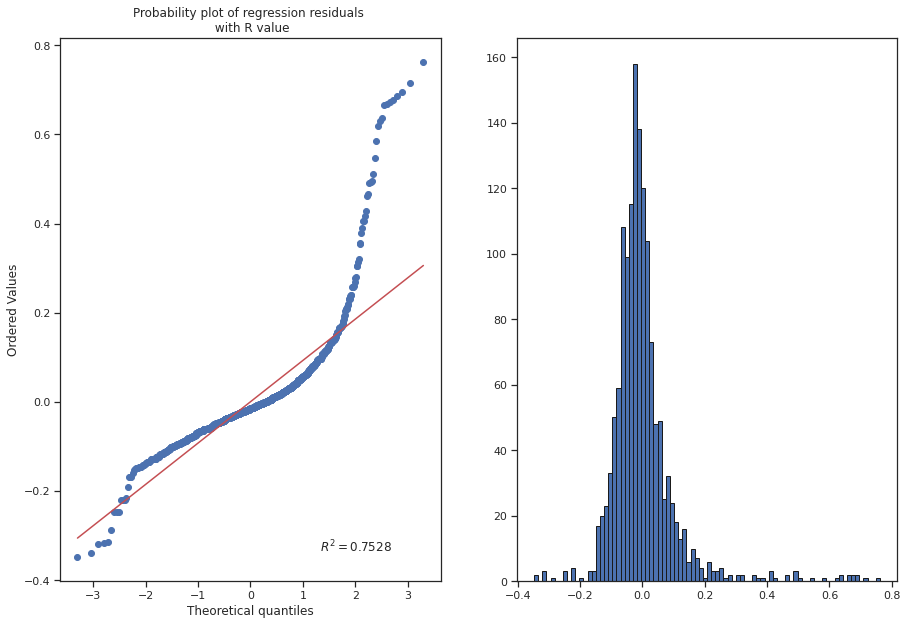

In [57]:
import pandas as pd
import scipy.stats as stats
import statsmodels.formula.api as smf


fig = plt.figure(figsize= (15, 10))
ax = fig.add_subplot(121)


normality_plot, stat = stats.probplot(lm.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of regression residuals \n with R value")
ax.set

ax2 = fig.add_subplot(122)
plt.hist(lm.resid, bins='auto', histtype='bar', ec='k') 

plt.show()

In [58]:
sm.stats.anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(group),1.0,0.240185,0.240185,20.777703,0.000006
C(theta),1.0,0.018863,0.018863,1.631757,0.201670
C(hfunc),2.0,0.245138,0.122569,10.603121,0.000027
C(source),1.0,0.027428,0.027428,2.372684,0.123698
C(qid),19.0,68.078024,3.583054,309.960156,0.000000
Residual,1415.0,16.357010,0.011560,NaN,NaN


Group and hfunc are significant.

In [59]:
acdata.groupby('group')['difference_ind'].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
auth,1080.0,0.493189,0.249682,0.068286,0.302500,0.505413,0.68149,1.488943
doc,360.0,0.463363,0.220535,0.066934,0.270985,0.470642,0.65284,0.884484


In [60]:
acdata.groupby('hfunc')['difference_ind'].describe()

,count,mean,std,min,25%,50%,75%,max
hfunc,,,,,,,,
linear,480.0,0.468327,0.226798,0.069636,0.298678,0.506533,0.646373,1.488943
max,480.0,0.489128,0.240864,0.068759,0.298678,0.476307,0.694745,1.488943
min,480.0,0.499741,0.259651,0.066934,0.310465,0.518439,0.683593,1.483408


Doc grouping and linear h function are the best.

##### util

In [61]:
formula = 'util ~ C(group) + C(theta) + C(hfunc) + C(source) + C(qid)'
lm = ols(formula, acdata).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   util   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     297.8
Date:                Tue, 31 May 2022   Prob (F-statistic):               0.00
Time:                        15:48:14   Log-Likelihood:                 2536.8
No. Observations:                1440   AIC:                            -5024.
Df Residuals:                    1415   BIC:                            -4892.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.1522      0.005     28.218      0.000       0.142       0.163
C(group)[T.doc]             0.0022      0.003      0.858      0.391      -0.003       0.007
C(theta)[T.99.0]            0.0089      0.002      4.049      0.000       0.005       0.013
C(hfunc)[T.max]             0.0005      0.003      0.190      0.850      -0.005       0.006
C(hfunc)[T.min]            -0.0005      0.003     -0.181      0.857      -0.006       0.005
C(source)[T.lambdamart]     0.0385      0.002     16.409      0.000       0.034       0.043
C(qid)[T.8940]              0.0964      0.007     13.796      0.000       0.083       0.110
C(qid)[T.10795]             0.0070      0.007      1.009      0.313      -0.007       0.021
C(qid)[T.12073]             0.2149      0.007     30.752      0.000       0.201       0.229
C(qid)[T.12096]            -0.0319      0.007     -4.559      0.000      -0.046      -0.018
C(qid)[T.12828]             0.0571      0.007      8.169      0.000       0.043       0.071
C(qid)[T.20363]             0.0770      0.007     11.012      0.000       0.063       0.091
C(qid)[T.25869]             0.0663      0.007      9.487      0.000       0.053       0.080
C(qid)[T.27887]             0.1574      0.007     22.529      0.000       0.144       0.171
C(qid)[T.30631]            -0.0107      0.007     -1.532      0.126      -0.024       0.003
C(qid)[T.31412]            -0.0146      0.007     -2.095      0.036      -0.028      -0.001
C(qid)[T.43018]            -0.0564      0.007     -8.070      0.000      -0.070      -0.043
C(qid)[T.49766]             0.3346      0.007     47.890      0.000       0.321       0.348
C(qid)[T.51432]             0.0595      0.007      8.522      0.000       0.046       0.073
C(qid)[T.54003]             0.0662      0.007      9.479      0.000       0.053       0.080
C(qid)[T.64062]             0.1150      0.007     16.451      0.000       0.101       0.129
C(qid)[T.66637]             0.1299      0.007     18.597      0.000       0.116       0.144
C(qid)[T.67404]             0.1034      0.007     14.791      0.000       0.090       0.117
C(qid)[T.70673]             0.0303      0.007      4.341      0.000       0.017       0.044
C(qid)[T.120668]            0.1806      0.007     25.840      0.000       0.167       0.194
==============================================================================
Omnibus:                      195.948   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1365.438
Skew:                           0.413   Prob(JB):                    3.15e-297
Kurtosis:                       7.699   Cond. No.                         27.3
==============================================================================

Notes:
[1] Standard Errors assum

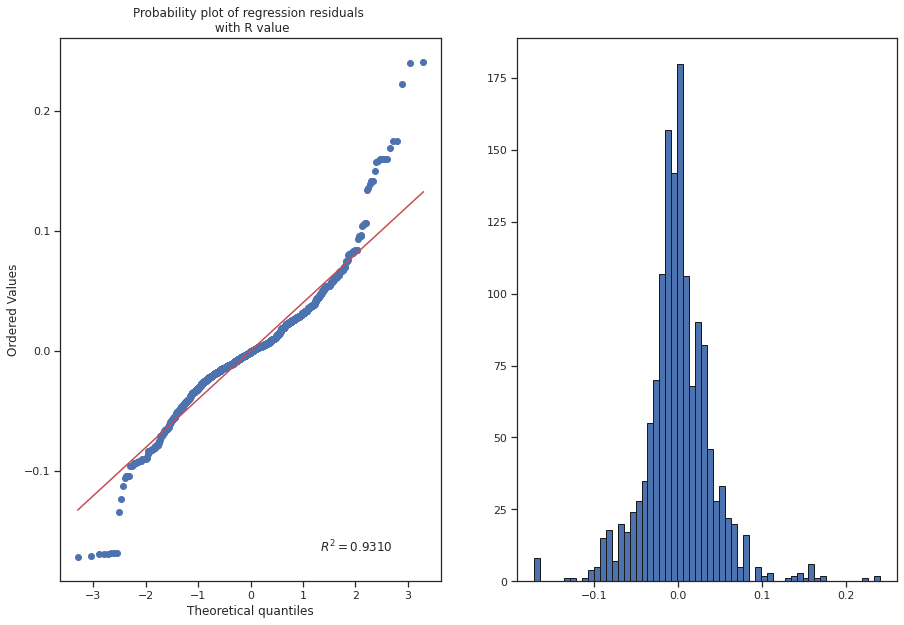

In [62]:
import pandas as pd
import scipy.stats as stats
import statsmodels.formula.api as smf


fig = plt.figure(figsize= (15, 10))
ax = fig.add_subplot(121)


normality_plot, stat = stats.probplot(lm.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of regression residuals \n with R value")
ax.set

ax2 = fig.add_subplot(122)
plt.hist(lm.resid, bins='auto', histtype='bar', ec='k') 

plt.show()

In [63]:
sm.stats.anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(group),1.0,0.001293,0.001293,0.735731,3.911770e-01
C(theta),1.0,0.028820,0.028820,16.395629,5.418923e-05
C(hfunc),2.0,0.000241,0.000121,0.068684,9.336248e-01
C(source),1.0,0.473277,0.473277,269.243563,1.591241e-55
C(qid),19.0,12.058458,0.634656,361.050764,0.000000e+00
Residual,1415.0,2.487290,0.001758,NaN,NaN


Theta and source are significant for utility.

In [64]:
acdata.groupby('theta')['util'].describe()

,count,mean,std,min,25%,50%,75%,max
theta,,,,,,,,
9.0,720.0,0.244682,0.102121,0.063157,0.163824,0.233427,0.290824,0.627806
99.0,720.0,0.253629,0.102285,0.051430,0.179057,0.238538,0.313274,0.639813


In [65]:
acdata.groupby('source')['util'].describe()

,count,mean,std,min,25%,50%,75%,max
source,,,,,,,,
KR,960.0,0.236336,0.098150,0.071727,0.157252,0.224482,0.275713,0.607025
lambdamart,480.0,0.274794,0.105563,0.051430,0.188377,0.267968,0.327514,0.639813


## RFR

In [66]:
rfrdata = experiments[(experiments.ranker == 'rfr') & ((experiments.source == 'TEXT_train') | (experiments.source == 'META_train') | (experiments.source == 'lambdamart_ndcg_noaug_nofeat'))]
rfrdata.source = rfrdata.source.apply(lambda x: 'KR' if '_train' in x else 'lambdamart')
rfrdata = rfrdata.reset_index(drop=True)

rfrdata.tail()

/home/pilmus/thesis/venv37/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,util,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor
235,0.402150,2.441503,1.577406,0.374586,0.257188,0.161792,0.322741,64062,rfr,KR,doc,-,-,-,-,-,-,-,-
236,0.150777,3.059053,2.380250,0.609978,0.483562,0.328282,0.330261,66637,rfr,KR,doc,-,-,-,-,-,-,-,-
237,0.050436,1.884897,1.770575,0.495148,0.495443,0.391637,0.411824,67404,rfr,KR,doc,-,-,-,-,-,-,-,-
238,0.251974,1.613103,1.143375,0.819353,0.290380,0.126659,0.121662,70673,rfr,KR,doc,-,-,-,-,-,-,-,-
239,0.200135,1.427024,1.173115,0.191163,0.196903,0.101635,0.456167,120668,rfr,KR,doc,-,-,-,-,-,-,-,-


In [67]:
from collections import Counter
Counter(rfrdata.source.to_list())

Counter({'lambdamart': 80, 'KR': 160})

##### group diff

In [68]:
formula = 'difference ~ C(group) + C(source) + C(qid)'
lm = ols(formula, rfrdata).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             difference   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     73.08
Date:                Tue, 31 May 2022   Prob (F-statistic):           1.92e-86
Time:                        15:48:14   Log-Likelihood:                -61.033
No. Observations:                 240   AIC:                             166.1
Df Residuals:                     218   BIC:                             242.6
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.6158      0.096      6.384      0.000       0.426       0.806
C(group)[T.doc]            -0.1134      0.049     -2.323      0.021      -0.210      -0.017
C(source)[T.lambdamart]    -0.0892      0.045     -1.990      0.048      -0.178      -0.001
C(qid)[T.8940]             -0.1650      0.134     -1.235      0.218      -0.428       0.098
C(qid)[T.10795]            -0.3892      0.134     -2.911      0.004      -0.653      -0.126
C(qid)[T.12073]            -0.3301      0.134     -2.470      0.014      -0.594      -0.067
C(qid)[T.12096]            -0.3743      0.134     -2.800      0.006      -0.638      -0.111
C(qid)[T.12828]            -0.5085      0.134     -3.805      0.000      -0.772      -0.245
C(qid)[T.20363]            -0.1049      0.134     -0.785      0.434      -0.368       0.159
C(qid)[T.25869]             0.2103      0.134      1.573      0.117      -0.053       0.474
C(qid)[T.27887]            -0.3448      0.134     -2.580      0.011      -0.608      -0.081
C(qid)[T.30631]             0.5768      0.134      4.315      0.000       0.313       0.840
C(qid)[T.31412]             3.4095      0.134     25.509      0.000       3.146       3.673
C(qid)[T.43018]            -0.1269      0.134     -0.949      0.344      -0.390       0.137
C(qid)[T.49766]            -0.3208      0.134     -2.400      0.017      -0.584      -0.057
C(qid)[T.51432]            -0.3293      0.134     -2.464      0.015      -0.593      -0.066
C(qid)[T.54003]            -0.3862      0.134     -2.889      0.004      -0.650      -0.123
C(qid)[T.64062]            -0.1618      0.134     -1.210      0.227      -0.425       0.102
C(qid)[T.66637]            -0.4195      0.134     -3.138      0.002      -0.683      -0.156
C(qid)[T.67404]            -0.2421      0.134     -1.812      0.071      -0.506       0.021
C(qid)[T.70673]             0.0970      0.134      0.726      0.469      -0.166       0.360
C(qid)[T.120668]           -0.4057      0.134     -3.036      0.003      -0.669      -0.142
==============================================================================
Omnibus:                       62.782   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1118.854
Skew:                          -0.414   Prob(JB):                    1.11e-243
Kurtosis:                      13.545   Cond. No.                         22.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

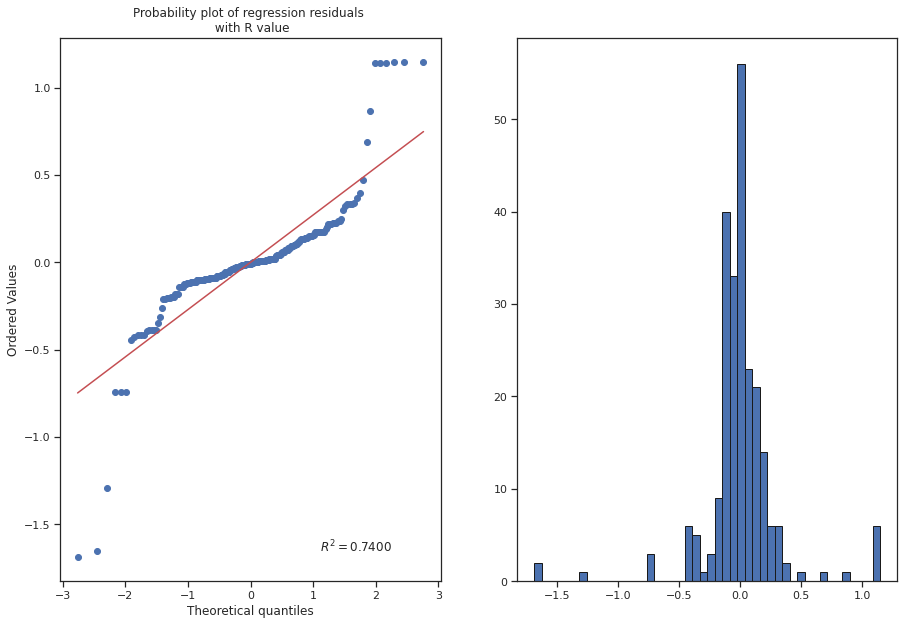

In [69]:
import pandas as pd
import scipy.stats as stats
import statsmodels.formula.api as smf


fig = plt.figure(figsize= (15, 10))
ax = fig.add_subplot(121)


normality_plot, stat = stats.probplot(lm.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of regression residuals \n with R value")
ax.set

ax2 = fig.add_subplot(122)
plt.hist(lm.resid, bins='auto', histtype='bar', ec='k') 

plt.show()

In [70]:
sm.stats.anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(group),1.0,0.578517,0.578517,5.396949,2.109365e-02
C(source),1.0,0.424317,0.424317,3.958423,4.788719e-02
C(qid),19.0,163.493647,8.604929,80.274835,3.119562e-87
Residual,218.0,23.368151,0.107193,NaN,NaN


Group and source are significant.

###### Tukey

In [71]:
rfrdata.groupby('group')['difference'].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
auth,180.0,0.570343,0.976803,0.011347,0.158037,0.269432,0.548360,5.169599
doc,60.0,0.456959,0.528737,0.050436,0.159663,0.234795,0.608351,2.618686


In [82]:
rfrdata.groupby('source')['difference'].describe()

,count,mean,std,min,25%,50%,75%,max
source,,,,,,,,
KR,160.0,0.571729,0.989916,0.011347,0.155993,0.266262,0.618955,5.169599
lambdamart,80.0,0.482532,0.632764,0.033985,0.165876,0.255460,0.548360,3.194016


Doc grouping is better.

##### ind

In [72]:
formula = 'difference_ind ~ C(group) + C(source) + C(qid)'
lm = ols(formula, rfrdata).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         difference_ind   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     49.04
Date:                Tue, 31 May 2022   Prob (F-statistic):           1.33e-70
Time:                        15:48:15   Log-Likelihood:                 74.425
No. Observations:                 240   AIC:                            -104.9
Df Residuals:                     218   BIC:                            -28.28
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.8572      0.055     15.625      0.000       0.749       0.965
C(group)[T.doc]            -0.2292      0.028     -8.258      0.000      -0.284      -0.174
C(source)[T.lambdamart]    -0.2027      0.025     -7.951      0.000      -0.253      -0.152
C(qid)[T.8940]             -0.0564      0.076     -0.742      0.459      -0.206       0.093
C(qid)[T.10795]            -0.2861      0.076     -3.763      0.000      -0.436      -0.136
C(qid)[T.12073]            -0.4817      0.076     -6.337      0.000      -0.632      -0.332
C(qid)[T.12096]             0.4789      0.076      6.300      0.000       0.329       0.629
C(qid)[T.12828]            -0.3964      0.076     -5.215      0.000      -0.546      -0.247
C(qid)[T.20363]            -0.2017      0.076     -2.654      0.009      -0.352      -0.052
C(qid)[T.25869]            -0.1737      0.076     -2.286      0.023      -0.324      -0.024
C(qid)[T.27887]            -0.6147      0.076     -8.087      0.000      -0.765      -0.465
C(qid)[T.30631]             0.4209      0.076      5.537      0.000       0.271       0.571
C(qid)[T.31412]             0.3926      0.076      5.165      0.000       0.243       0.542
C(qid)[T.43018]            -0.1193      0.076     -1.570      0.118      -0.269       0.030
C(qid)[T.49766]            -0.4846      0.076     -6.376      0.000      -0.634      -0.335
C(qid)[T.51432]            -0.4760      0.076     -6.262      0.000      -0.626      -0.326
C(qid)[T.54003]             0.4517      0.076      5.942      0.000       0.302       0.602
C(qid)[T.64062]            -0.1619      0.076     -2.130      0.034      -0.312      -0.012
C(qid)[T.66637]             0.3600      0.076      4.736      0.000       0.210       0.510
C(qid)[T.67404]             0.3729      0.076      4.906      0.000       0.223       0.523
C(qid)[T.70673]             0.1795      0.076      2.361      0.019       0.030       0.329
C(qid)[T.120668]           -0.4235      0.076     -5.572      0.000      -0.573      -0.274
==============================================================================
Omnibus:                        5.899   Durbin-Watson:                   1.486
Prob(Omnibus):                  0.052   Jarque-Bera (JB):                6.878
Skew:                           0.212   Prob(JB):                       0.0321
Kurtosis:                       3.712   Cond. No.                         22.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

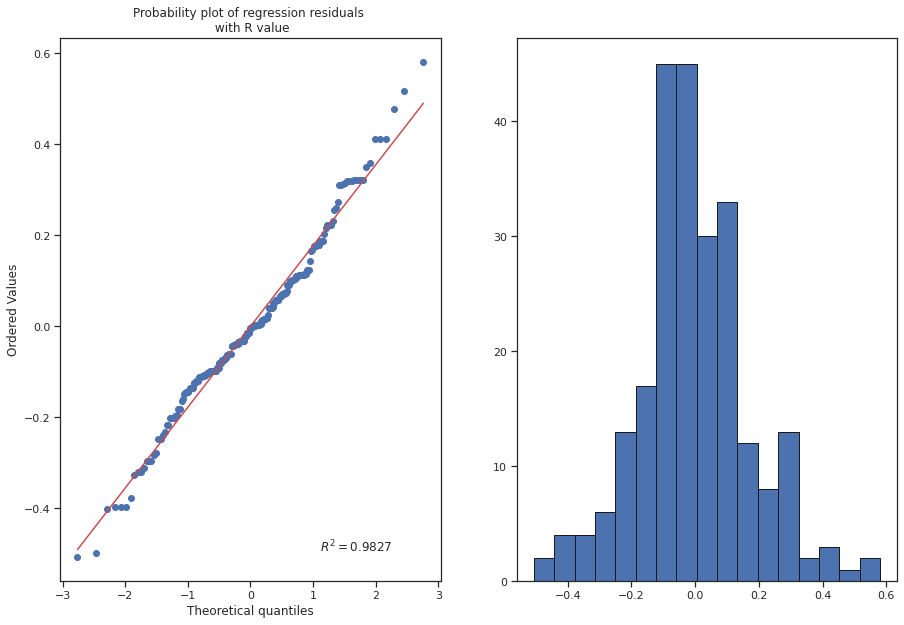

In [73]:
import pandas as pd
import scipy.stats as stats
import statsmodels.formula.api as smf


fig = plt.figure(figsize= (15, 10))
ax = fig.add_subplot(121)


normality_plot, stat = stats.probplot(lm.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of regression residuals \n with R value")
ax.set

ax2 = fig.add_subplot(122)
plt.hist(lm.resid, bins='auto', histtype='bar', ec='k') 

plt.show()

In [74]:
sm.stats.anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(group),1.0,2.363998,2.363998,68.189929,1.425661e-14
C(source),1.0,2.191441,2.191441,63.212492,9.925514e-14
C(qid),19.0,31.144852,1.639203,47.283089,1.925904e-66
Residual,218.0,7.557590,0.034668,NaN,NaN


Group is significant, source is significant.

In [75]:
rfrdata.groupby('group')['difference_ind'].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
auth,180.0,0.728613,0.458438,0.096757,0.361557,0.618561,1.015087,1.629713
doc,60.0,0.499412,0.235577,0.110863,0.348338,0.530865,0.653496,0.931690


In [81]:
rfrdata.groupby('source')['difference_ind'].describe()

,count,mean,std,min,25%,50%,75%,max
source,,,,,,,,
KR,160.0,0.738881,0.462662,0.115841,0.348338,0.602330,1.016067,1.629713
lambdamart,80.0,0.536176,0.298339,0.096757,0.333382,0.497804,0.765604,1.099414


Doc grouping and linear h function are the best.

##### util

In [83]:
formula = 'util ~ C(group) + C(source) + C(qid)'
lm = ols(formula, rfrdata).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   util   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     35.89
Date:                Tue, 31 May 2022   Prob (F-statistic):           5.05e-59
Time:                        15:52:44   Log-Likelihood:                 256.88
No. Observations:                 240   AIC:                            -469.8
Df Residuals:                     218   BIC:                            -393.2
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.0383      0.026      1.495      0.136      -0.012       0.089
C(group)[T.doc]             0.0347      0.013      2.670      0.008       0.009       0.060
C(source)[T.lambdamart]     0.0036      0.012      0.299      0.765      -0.020       0.027
C(qid)[T.8940]              0.3421      0.036      9.626      0.000       0.272       0.412
C(qid)[T.10795]             0.1205      0.036      3.389      0.001       0.050       0.191
C(qid)[T.12073]             0.2329      0.036      6.552      0.000       0.163       0.303
C(qid)[T.12096]             0.0019      0.036      0.053      0.957      -0.068       0.072
C(qid)[T.12828]             0.4706      0.036     13.242      0.000       0.401       0.541
C(qid)[T.20363]             0.3180      0.036      8.947      0.000       0.248       0.388
C(qid)[T.25869]             0.1501      0.036      4.223      0.000       0.080       0.220
C(qid)[T.27887]             0.3825      0.036     10.762      0.000       0.312       0.453
C(qid)[T.30631]             0.0130      0.036      0.365      0.715      -0.057       0.083
C(qid)[T.31412]             0.0019      0.036      0.054      0.957      -0.068       0.072
C(qid)[T.43018]             0.2056      0.036      5.786      0.000       0.136       0.276
C(qid)[T.49766]             0.5500      0.036     15.475      0.000       0.480       0.620
C(qid)[T.51432]             0.1665      0.036      4.685      0.000       0.096       0.237
C(qid)[T.54003]             0.0634      0.036      1.783      0.076      -0.007       0.133
C(qid)[T.64062]             0.1622      0.036      4.564      0.000       0.092       0.232
C(qid)[T.66637]             0.1862      0.036      5.240      0.000       0.116       0.256
C(qid)[T.67404]             0.1478      0.036      4.157      0.000       0.078       0.218
C(qid)[T.70673]             0.1384      0.036      3.896      0.000       0.068       0.208
C(qid)[T.120668]            0.3306      0.036      9.302      0.000       0.261       0.401
==============================================================================
Omnibus:                        1.745   Durbin-Watson:                   1.871
Prob(Omnibus):                  0.418   Jarque-Bera (JB):                1.518
Skew:                          -0.190   Prob(JB):                        0.468
Kurtosis:                       3.083   Cond. No.                         22.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

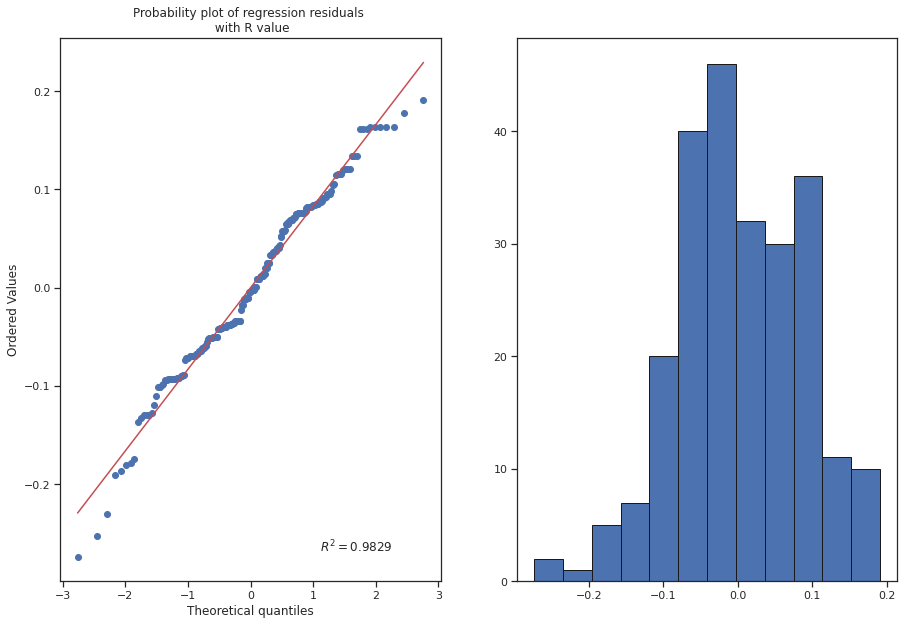

In [84]:
import pandas as pd
import scipy.stats as stats
import statsmodels.formula.api as smf


fig = plt.figure(figsize= (15, 10))
ax = fig.add_subplot(121)


normality_plot, stat = stats.probplot(lm.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of regression residuals \n with R value")
ax.set

ax2 = fig.add_subplot(122)
plt.hist(lm.resid, bins='auto', histtype='bar', ec='k') 

plt.show()

In [85]:
sm.stats.anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(group),1.0,0.054038,0.054038,7.130281,8.150403e-03
C(source),1.0,0.000676,0.000676,0.089219,7.654567e-01
C(qid),19.0,5.658004,0.297790,39.293211,1.152399e-59
Residual,218.0,1.652147,0.007579,NaN,NaN


Group is significant for utility.

In [86]:
rfrdata.groupby('group')['util'].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
auth,180.0,0.238735,0.193614,0.000071,0.105833,0.195252,0.321786,0.673985
doc,60.0,0.273388,0.100910,0.100346,0.188329,0.280985,0.335950,0.525342
